# Прогнозирование продаж в магазинах офлаин-ритейлера в США

## Импорт библиотек и загрузка данных

In [ ]:
!pip install catboost sktime

In [ ]:
!unzip /content/data.zip

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pickle
from sklearn.metrics import mean_absolute_error
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
from catboost import Pool, CatBoostRegressor

warnings.filterwarnings("ignore")

## Класс для прогнозирования

In [ ]:
class SalePredict:
    """
    Class to predict sales using CatBoostRegressor model.

    Methods:
    - __init__(store_id): Initialize SalePredict object with store_id.
    - split_train_test(df, start_date, end_date): Split dataframe into train
    and test sets.
    - make_df(sales, calendar, prev_lags=None): Create dataframe with lag
    features for training.
    - fit(train_df): Fit CatBoostRegressor model on training data.
    - predict(test_df, period=None): Make predictions on test data.
    - metrics_report(result_df, detailed=False): Generate metrics report for
    model evaluation.
    - save_model(path): Save trained models to a file.
    - load_model(path): Load trained models from a file.
    - save_feature_names(path): Save feature names to a file.
    - load_feature_names(path): Load feature names from a file.
    """
    def __init__(self, store_id):
        """
        Initialize SalePredict object with store_id.

        Parameters:
        - store_id (int): The unique identifier for the store.

        Attributes:
        - store_id (int): The unique identifier for the store.
        - model_dict (dict): A dictionary to store trained models.

        Returns:
        - None
        """
        self.store_id = store_id
        self.model_dict = {}

    def _make_df(self, sales, calendar):
        """
        Create a dataframe with lag features for training.

        Parameters:
        - sales (DataFrame): The sales data containing store_id and other
        relevant columns.
        - calendar (DataFrame): The calendar data containing date_id and other
        relevant columns.

        Returns:
        - df (DataFrame): The dataframe with lag features for training, after
        merging sales and calendar data,
        dropping unnecessary columns, filling missing values, and converting
        date column to datetime format.
        """
        store_sales = sales[sales['store_id']==self.store_id]
        df = store_sales.merge(calendar, how='left', on='date_id')
        df = df.drop(['store_id', 'date_id', 'wm_yr_wk', 'weekday', 'event_name_2',
                    'event_type_2', 'CASHBACK_STORE_2', 'CASHBACK_STORE_3'],
                    axis=1)
        df['event_name_1'] = df['event_name_1'].fillna('not_event')
        df['event_type_1'] = df['event_type_1'].fillna('not_event')
        df['date'] = pd.to_datetime(df['date'])
        return df

    def _features_regression(self, df, target_col):
        """
        Create lag features in the dataframe for regression modeling.

        Parameters:
        - df (DataFrame): The dataframe containing the target column for lag
        feature creation.
        - target_col (str): The name of the target column for which lag features
        are created.

        Returns:
        - df (DataFrame): The dataframe with lag features added for the target
        column based on the specified lag periods.
        """
        feature_lags = [94, 95, 96, 97, 98, 99, 100]
        for lag in feature_lags:
            df.loc[:, f'{target_col}_lag_{lag}'] = df[target_col].shift(
                                                                    periods=lag,
                                                                    fill_value=0
                                                                    ).values

        return df

    def split_train_test(self, df, start_date, end_date):
        """
        Split the input dataframe into training and validation sets based on the
        specified start and end dates.

        Parameters:
        - df (DataFrame): The input dataframe containing the data to be split.
        - start_date (str): The start date for the validation set in
        'YYYY-MM-DD' format.
        - end_date (str): The end date for the validation set in 'YYYY-MM-DD'
        format.

        Returns:
        - train_df (DataFrame): The training set dataframe containing data
        before the validation period.
        - val_df (DataFrame): The validation set dataframe containing data
        within the specified date range.
        """
        valid_split = len(pd.date_range(start_date, end_date))

        val_df = df.groupby('item_id').tail(valid_split)
        train_df = df.drop(val_df.index)


        return train_df, val_df

    def _get_feature_names(self, df):
        """
        Create a list of feature names and categorical feature names based on
        the input dataframe.

        Parameters:
        - df (DataFrame): The input dataframe containing the features.

        Returns:
        - None
        """
        self.feature_names = df.columns.drop(['item_id', 'cnt']).tolist()
        self.cat_features = ['event_name_1', 'event_type_1']

    def make_df(self, sales, calendar, prev_lags=None):
        """
        Create a dataframe with lag features for training.

        Parameters:
        - sales (DataFrame): The sales data containing store_id and other
        relevant columns.
        - calendar (DataFrame): The calendar data containing date_id and other
        relevant columns.
        - prev_lags (DataFrame, optional): Previous lag features dataframe to be
        concatenated with the new dataframe.

        Returns:
        - df_items (DataFrame): The dataframe with lag features for training,
        after merging sales and calendar data,
        dropping unnecessary columns, filling missing values, and converting
        date column to datetime format.
        """
        df = self._make_df(sales, calendar)
        df_min_date = df['date'].min()
        df_items_list = []
        if isinstance(prev_lags, pd.DataFrame):
            df = pd.concat([prev_lags, df])
        for item in df['item_id'].unique():
            df_f = self._features_regression(df, 'cnt')
            df_items_list.append(df_f)
        df_items = pd.concat(df_items_list)

        df_items = df_items[df_items['date'] >= df_min_date]

        return df_items

    def fit(self, train_df):
        """
        Fit the CatBoostRegressor model on the training data for each item in
        the dataset.

        Parameters:
        - train_df (DataFrame): The training dataframe containing the features
        and target column for each item.

        Returns:
        - None
        """
        self._get_feature_names(train_df)

        models = {}

        for item in train_df['item_id'].unique():
            train_data = train_df[train_df['item_id']==item]

            train_pool = Pool(
                train_data[self.feature_names],
                train_data['cnt'],
                cat_features = self.cat_features,
                feature_names=self.feature_names
            )

            cb_model = CatBoostRegressor(
                        n_estimators=700,
                        random_state=52,
                        early_stopping_rounds=75,
                        verbose=0,
                        eval_metric='MAPE'
            )

            cb_model.fit(train_pool)
            models[item] = cb_model

            self.model_dict = models

    def predict(self, test_df, period=None):
        """
        Make predictions on the test data.

        Parameters:
        - test_df (DataFrame): The test dataframe containing the data for which
        predictions are to be made.
        - period (int, optional): The number of periods to predict into the
        future for each item. If not specified, predictions are made for all available periods.

        Returns:
        - pred_df (DataFrame): A dataframe containing the item_id, date, and the
        predicted sales count (cnt_pred) for each item in the test data.
        """
        pred_all = []
        for item in test_df['item_id'].unique():
            test_data = test_df[test_df['item_id']==item]
            if period:
                test_data = test_df[test_df['item_id']==item][:period]

            test_pool = Pool(
                test_data[self.feature_names],
                cat_features = self.cat_features,
                feature_names=self.feature_names
            )

            cb_model = self.model_dict[item]
            pred = cb_model.predict(test_pool)
            test_data['cnt_pred'] = pred
            pred_all.append(test_data)

        return pd.concat(pred_all)[['item_id', 'date', 'cnt_pred']]

    def metrics_report(self, result_df, detailed=False):
        """
        Generate metrics report for model evaluation.

        Parameters:
        - result_df (DataFrame): The dataframe containing the actual sales count
        ('cnt') and the predicted sales count ('cnt_pred') for each item.
        - detailed (bool, optional): If True, detailed metrics are calculated
        for each item separately. If False, overall metrics are calculated for
        all items combined. Default is False.

        Returns:
        - If detailed=True:
            - metrics_df (DataFrame): A dataframe containing the item_id,
            mean absolute error (mae), and mean absolute percentage error (mape)
            for each item in the result_df.
        - If detailed=False:
            - metrics_dict (dict): A dictionary containing the overall
            mean absolute error (mae) and mean absolute percentage error (mape)
            for all items combined.
        """
        if detailed:
            metrics_dict = {
                'item_id': [],
                'mae': [],
                'smape': []
            }
            for item in result_df['item_id'].unique():
                data = result_df[result_df['item_id']==item]

                mae = mean_absolute_error(data['cnt'], data['cnt_pred'])
                mape = mean_absolute_percentage_error(data['cnt'],
                                                      data['cnt_pred'],
                                                      symmetric=True)

                metrics_dict['item_id'].append(item)
                metrics_dict['mae'].append(mae)
                metrics_dict['smape'].append(mape)

            metrics_df = pd.DataFrame.from_dict(metrics_dict)
            return metrics_df

        else:
            metrics_dict = {
                'mae': mean_absolute_error(result_df['cnt'], result_df['cnt_pred']),
                'smape': mean_absolute_percentage_error(result_df['cnt'],
                                                        result_df['cnt_pred'],
                                                        symmetric=True)
            }

            return  metrics_dict

    def save_model(self, path):
        with open(path, 'wb') as file:
            pickle.dump(self.model_dict, file)

    def load_model(self, path):
        with open(path, 'rb') as file:
            self.model_dict = pickle.load(file)

    def save_feature_names(self, path):
        names = {
            'feature_names': self.feature_names,
            'cat_features': self.cat_features
            }

        with open(path, 'wb') as file:
            pickle.dump(names, file)

    def load_feature_names(self, path):
        with open(path, 'rb') as file:
            names_dict = pickle.load(file)

        self.feature_names = names_dict['feature_names']
        self.cat_features = names_dict['cat_features']

## Обучение

In [ ]:
STORE_ID = 'STORE_1'

In [ ]:
sales = pd.read_csv('data/shop_sales.csv')
calendar = pd.read_csv('data/shop_sales_dates.csv')

In [ ]:
start_date = '2015-10-21'
end_date = '2016-01-21'
valid_split = len(pd.date_range(start_date, end_date))
valid_split

93

In [ ]:
sp = SalePredict(STORE_ID)
df = sp.make_df(sales, calendar)

train_df, val_df = sp.split_train_test(df, start_date, end_date)

In [ ]:
train_df.head(5)

,item_id,cnt,date,wday,month,year,event_name_1,event_type_1,CASHBACK_STORE_1,cnt_lag_94,cnt_lag_95,cnt_lag_96,cnt_lag_97,cnt_lag_98,cnt_lag_99,cnt_lag_100
0,STORE_1_064,0,2011-01-29,1,1,2011,not_event,not_event,0,0,0,0,0,0,0,0
1,STORE_1_064,1,2011-01-30,2,1,2011,not_event,not_event,0,0,0,0,0,0,0,0
2,STORE_1_064,0,2011-01-31,3,1,2011,not_event,not_event,0,0,0,0,0,0,0,0
3,STORE_1_064,0,2011-02-01,4,2,2011,not_event,not_event,0,0,0,0,0,0,0,0
4,STORE_1_064,0,2011-02-02,5,2,2011,not_event,not_event,1,0,0,0,0,0,0,0


In [ ]:
train_df['date'].min(), train_df['date'].max()

(Timestamp('2011-01-29 00:00:00'), Timestamp('2015-10-20 00:00:00'))

In [ ]:
val_df['date'].min(), val_df['date'].max()

(Timestamp('2015-10-21 00:00:00'), Timestamp('2016-01-21 00:00:00'))

In [ ]:
sp.fit(train_df)

In [ ]:
sp.save_model('models.pkl')
sp.save_feature_names('feature_names.pkl')

## Прогнозы на валидации

In [ ]:
sp2 = SalePredict(STORE_ID)
sp2.load_model('models.pkl')
sp2.load_feature_names('feature_names.pkl')

In [ ]:
val_df = val_df.reset_index(drop=True)

In [ ]:
val_pred = sp2.predict(val_df)
val_pred_eval = val_pred.merge(val_df, how='left', on=['item_id', 'date'])
display(sp2.metrics_report(val_pred_eval, detailed=True))
print(sp2.metrics_report(val_pred_eval, detailed=False))

,item_id,mae,smape
0,STORE_1_064,0.316100,1.939322
1,STORE_1_065,0.787670,1.793395
2,STORE_1_325,3.668604,0.848352
3,STORE_1_376,0.706115,1.879262
4,STORE_1_090,28.732539,0.927246
5,STORE_1_252,5.580779,0.393903
6,STORE_1_339,2.217828,0.775393
7,STORE_1_546,1.760690,0.665049
8,STORE_1_547,9.994688,1.005351
9,STORE_1_555,5.805390,0.267730


{'mae': 5.846439852261166, 'smape': 0.8953696390080759}


In [ ]:
val_pred = sp2.predict(val_df, period=valid_split)
val_pred_eval = val_pred.merge(val_df, how='left', on=['item_id', 'date'])
display(sp2.metrics_report(val_pred_eval, detailed=True))
print(sp2.metrics_report(val_pred_eval, detailed=False))

,item_id,mae,smape
0,STORE_1_064,0.316100,1.939322
1,STORE_1_065,0.787670,1.793395
2,STORE_1_325,3.668604,0.848352
3,STORE_1_376,0.706115,1.879262
4,STORE_1_090,28.732539,0.927246
5,STORE_1_252,5.580779,0.393903
6,STORE_1_339,2.217828,0.775393
7,STORE_1_546,1.760690,0.665049
8,STORE_1_547,9.994688,1.005351
9,STORE_1_555,5.805390,0.267730


{'mae': 5.846439852261166, 'smape': 0.8953696390080759}


In [ ]:
val_pred = sp2.predict(val_df, period=7)
val_pred_eval = val_pred.merge(val_df, how='left', on=['item_id', 'date'])
display(sp2.metrics_report(val_pred_eval, detailed=True))
print(sp2.metrics_report(val_pred_eval, detailed=False))

,item_id,mae,smape
0,STORE_1_064,0.045962,2.000000
1,STORE_1_065,0.551275,1.912515
2,STORE_1_325,3.338208,0.902671
3,STORE_1_376,0.614639,1.830442
4,STORE_1_090,16.892436,0.227332
5,STORE_1_252,5.773275,0.309617
6,STORE_1_339,2.167884,1.329041
7,STORE_1_546,2.423399,0.805876
8,STORE_1_547,6.818348,1.239797
9,STORE_1_555,4.447467,0.182831


{'mae': 4.489331395553237, 'smape': 0.9174487700446263}


In [ ]:
val_pred = sp2.predict(val_df, period=30)
val_pred_eval = val_pred.merge(val_df, how='left', on=['item_id', 'date'])
display(sp2.metrics_report(val_pred_eval, detailed=True))
print(sp2.metrics_report(val_pred_eval, detailed=False))

,item_id,mae,smape
0,STORE_1_064,0.229728,1.895027
1,STORE_1_065,0.844485,1.796268
2,STORE_1_325,3.285297,0.978380
3,STORE_1_376,0.566710,1.902909
4,STORE_1_090,15.501916,0.229115
5,STORE_1_252,5.733643,0.364330
6,STORE_1_339,2.177090,0.758354
7,STORE_1_546,2.165348,0.858902
8,STORE_1_547,8.170274,1.032911
9,STORE_1_555,6.062729,0.265997


{'mae': 4.719339391350552, 'smape': 0.8553498945535745}


## Прогнозы на тесте

In [ ]:
!unzip /content/test_data.zip

Archive:  /content/test_data.zip
  inflating: test data/shop_sales_prices_test.csv  
  inflating: test data/shop_sales_test.csv  
  inflating: test data/shop_sales_dates_test.csv  


In [ ]:
sales_test = pd.read_csv('/content/test data/shop_sales_test.csv')
calendar_test = pd.read_csv('/content/test data/shop_sales_dates_test.csv')

In [ ]:
df_test = sp2.make_df(sales_test, calendar_test, prev_lags=df)

In [ ]:
df_test.head()

,item_id,cnt,date,wday,month,year,event_name_1,event_type_1,CASHBACK_STORE_1,cnt_lag_94,cnt_lag_95,cnt_lag_96,cnt_lag_97,cnt_lag_98,cnt_lag_99,cnt_lag_100
0,STORE_1_064,0,2016-01-22,7,1,2016,not_event,not_event,0,5.0,0.0,0.0,17.0,7.0,5.0,3.0
1,STORE_1_064,0,2016-01-23,1,1,2016,not_event,not_event,0,4.0,5.0,0.0,0.0,17.0,7.0,5.0
2,STORE_1_064,0,2016-01-24,2,1,2016,not_event,not_event,0,6.0,4.0,5.0,0.0,0.0,17.0,7.0
3,STORE_1_064,0,2016-01-25,3,1,2016,not_event,not_event,0,2.0,6.0,4.0,5.0,0.0,0.0,17.0
4,STORE_1_064,0,2016-01-26,4,1,2016,not_event,not_event,0,11.0,2.0,6.0,4.0,5.0,0.0,0.0


In [ ]:
val_df['date'].min(), val_df['date'].max()

(Timestamp('2015-10-21 00:00:00'), Timestamp('2016-01-21 00:00:00'))

In [ ]:
df_test['date'].min(), df_test['date'].max()

(Timestamp('2016-01-22 00:00:00'), Timestamp('2016-04-24 00:00:00'))

In [ ]:
df_test['date'].max() - df_test['date'].min()

Timedelta('93 days 00:00:00')

In [ ]:
test_pred = sp2.predict(df_test)
test_pred_eval = test_pred.merge(df_test, how='left', on=['item_id', 'date'])
display(sp2.metrics_report(test_pred_eval, detailed=True))
print(sp2.metrics_report(test_pred_eval, detailed=False))

,item_id,mae,smape
0,STORE_1_064,0.598891,1.828937
1,STORE_1_065,0.908508,1.816778
2,STORE_1_325,4.134055,0.927347
3,STORE_1_376,0.909786,1.754861
4,STORE_1_090,24.121010,0.308574
5,STORE_1_252,5.795333,0.409689
6,STORE_1_339,3.375753,0.700481
7,STORE_1_546,2.292966,0.799979
8,STORE_1_547,8.666948,0.694495
9,STORE_1_555,6.972058,0.285956


{'mae': 6.05230192935033, 'smape': 0.8222903501622483}


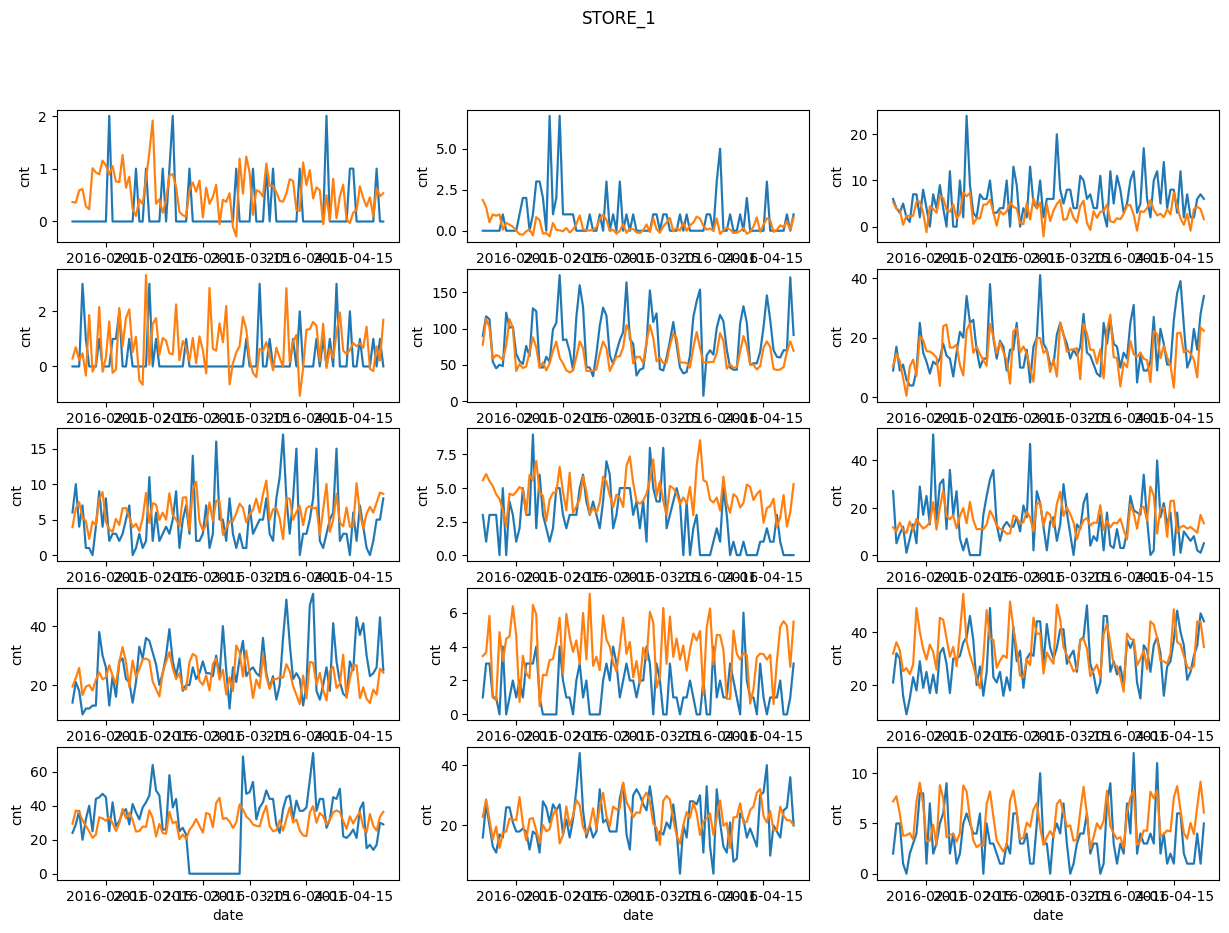

In [ ]:
fig,ax = plt.subplots(5,3,figsize=(15,10))

for i, art in enumerate(test_pred_eval['item_id'].unique()):
    data = test_pred_eval[test_pred_eval['item_id']==art]
    data.set_index('date')
    sns.lineplot(data=data,
                 x='date',y='cnt',ax = ax[i//3][i%3])
    sns.lineplot(data=data,
                 x='date',y='cnt_pred',ax = ax[i//3][i%3])
plt.suptitle(STORE_ID)
plt.show()

In [ ]:
test_pred = sp2.predict(df_test, period=30)
test_pred_eval = test_pred.merge(df_test, how='left', on=['item_id', 'date'])
display(sp2.metrics_report(test_pred_eval, detailed=True))
print(sp2.metrics_report(test_pred_eval, detailed=False))

,item_id,mae,smape
0,STORE_1_064,0.710593,1.806333
1,STORE_1_065,1.483976,1.864531
2,STORE_1_325,3.532871,0.870613
3,STORE_1_376,1.024492,1.780420
4,STORE_1_090,24.151000,0.296064
5,STORE_1_252,5.606201,0.448498
6,STORE_1_339,2.908682,0.710074
7,STORE_1_546,2.028506,0.605700
8,STORE_1_547,10.149837,0.793943
9,STORE_1_555,5.845101,0.267919


{'mae': 5.8738204718963845, 'smape': 0.7984341578930565}


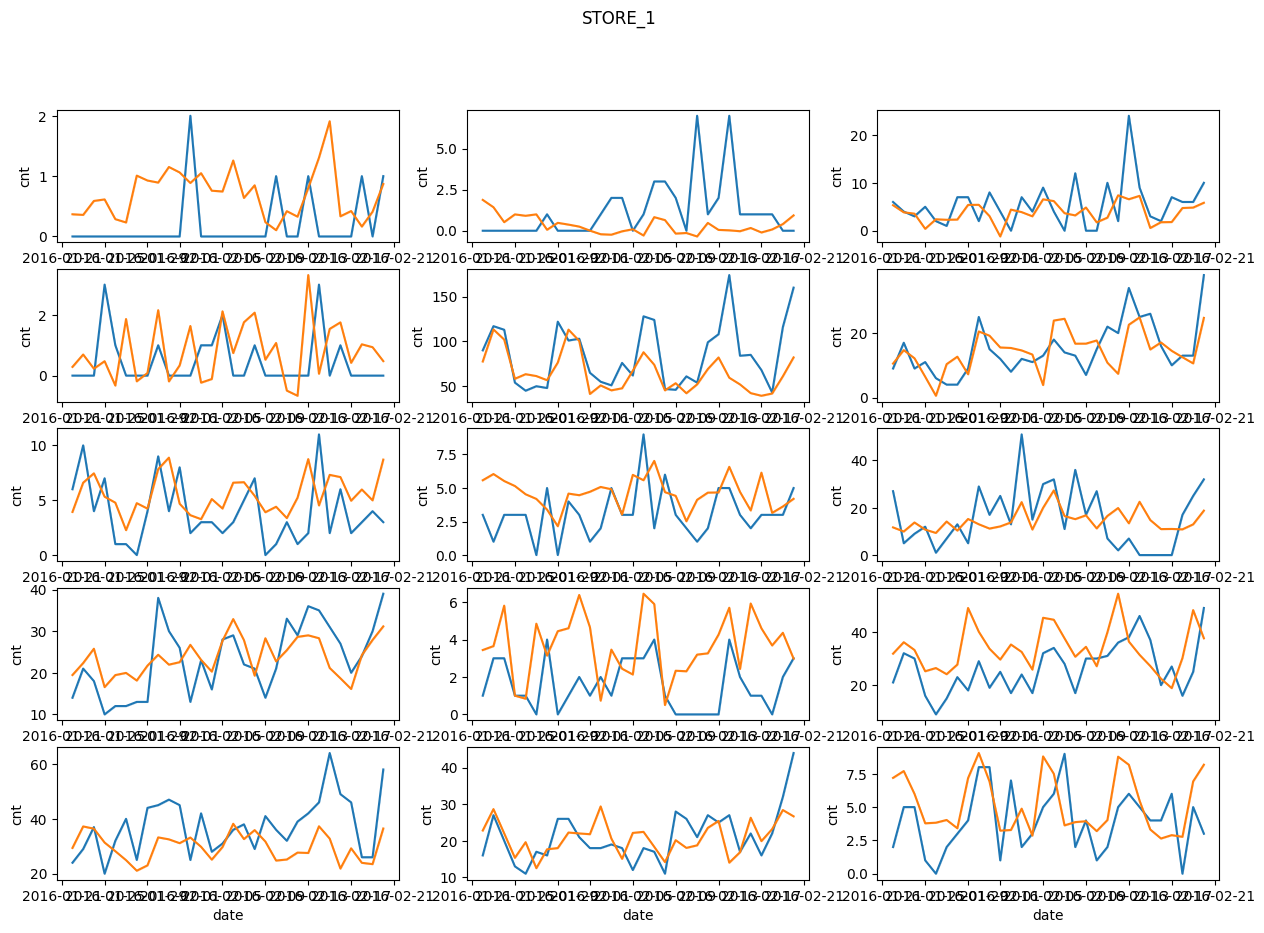

In [ ]:
fig,ax = plt.subplots(5,3,figsize=(15,10))

for i, art in enumerate(test_pred_eval['item_id'].unique()):
    data = test_pred_eval[test_pred_eval['item_id']==art]
    data.set_index('date')
    sns.lineplot(data=data,
                 x='date',y='cnt',ax = ax[i//3][i%3])
    sns.lineplot(data=data,
                 x='date',y='cnt_pred',ax = ax[i//3][i%3])
plt.suptitle(STORE_ID)
plt.show()

In [ ]:
test_pred = sp2.predict(df_test, period=7)
test_pred_eval = test_pred.merge(df_test, how='left', on=['item_id', 'date'])
display(sp2.metrics_report(test_pred_eval, detailed=True))
print(sp2.metrics_report(test_pred_eval, detailed=False))

,item_id,mae,smape
0,STORE_1_064,0.493412,2.000000
1,STORE_1_065,1.096074,1.967752
2,STORE_1_325,1.763477,0.571082
3,STORE_1_376,1.016562,1.921884
4,STORE_1_090,9.975024,0.152664
5,STORE_1_252,4.575888,0.673877
6,STORE_1_339,2.912113,0.826791
7,STORE_1_546,2.803914,0.849107
8,STORE_1_547,6.351857,0.643031
9,STORE_1_555,5.951687,0.362587


{'mae': 4.027264857345295, 'smape': 0.8176745900525938}


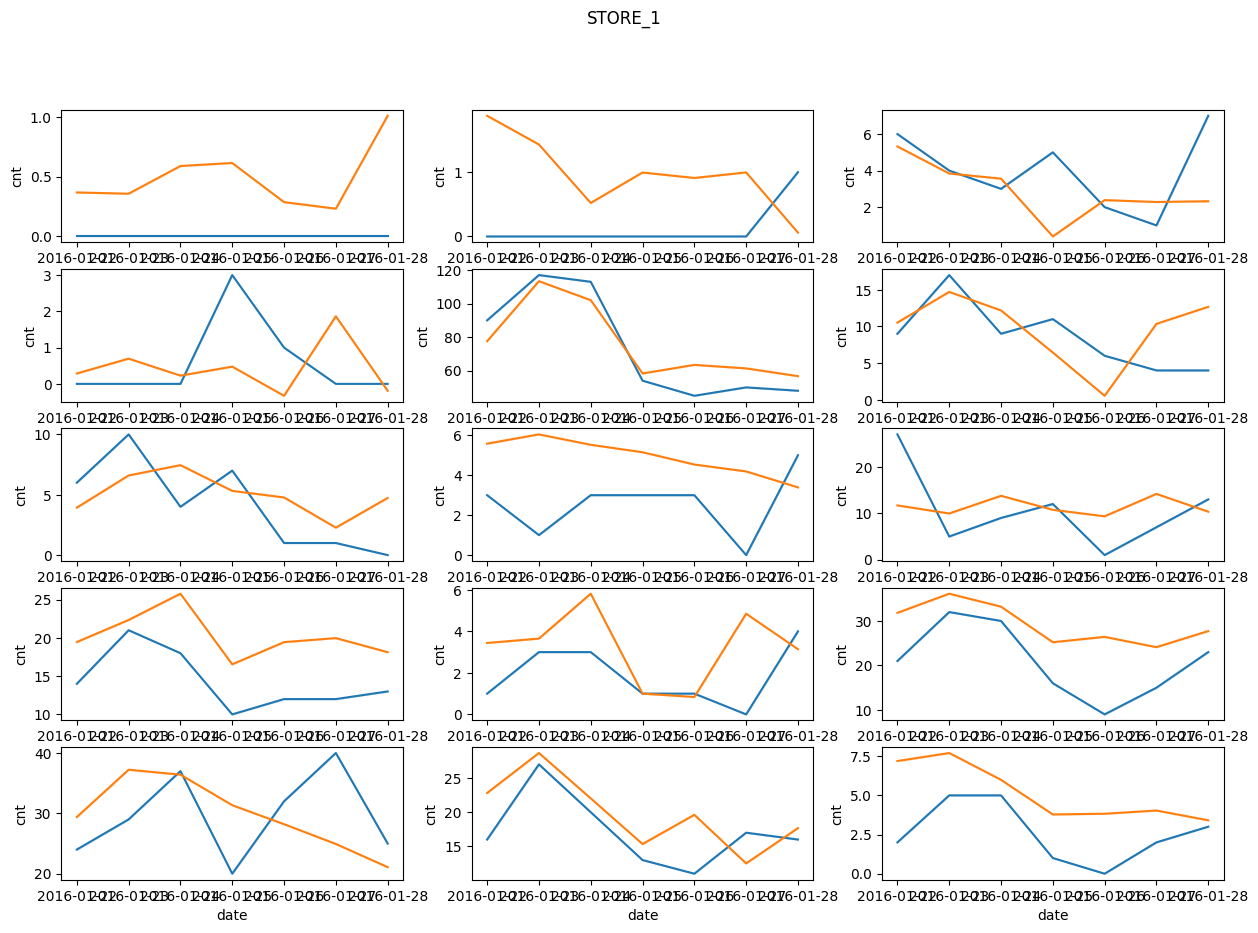

In [ ]:
fig,ax = plt.subplots(5,3,figsize=(15,10))

for i, art in enumerate(test_pred_eval['item_id'].unique()):
    data = test_pred_eval[test_pred_eval['item_id']==art]
    data.set_index('date')
    sns.lineplot(data=data,
                 x='date',y='cnt',ax = ax[i//3][i%3])
    sns.lineplot(data=data,
                 x='date',y='cnt_pred',ax = ax[i//3][i%3])
plt.suptitle(STORE_ID)
plt.show()